<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/model_descriptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generate tokenized descriptions and reviews

In [1]:
!git clone https://github.com/dernameistegal/airbnb_price.git

fatal: destination path 'airbnb_price' already exists and is not an empty directory.


In [15]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut
device = ut.get_device()

[Errno 2] No such file or directory: 'airbnb_price'
/content/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB


In [2]:
%%capture
!pip install transformers
!pip install requests
!pip install captum

# Sentiment Analysis

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Explore the dataset

In [4]:
path = "/content/drive/MyDrive/Colab/airbnb/data/reviews/df.pickle"
data = pd.read_pickle(path)
input_ids, attention_masks, labels = data['desc_input_ids'], data['desc_attention_masks'], data['log_price']

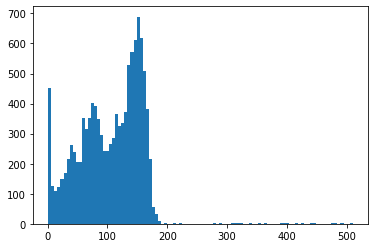

In [8]:
# TODO Visualize the length of the reviews in your dataset
def count_words(string):
    return len(string.split())

review_lengths = np.vectorize(count_words)(data['description_en'])

a = plt.hist(review_lengths, bins = 100)
plt.show()

In [9]:
%tensorflow_version 1.x
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

TensorFlow 1.x selected.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Training, Validation, Test Split

Use 15% of the dataset as validation and test set, respectively. Use the other 70% for training.

In [5]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)  
ids_train, ids_val = np.stack(input_ids[train_ids]), np.stack(input_ids[val_ids])
labels_train, labels_val = np.stack(labels[train_ids]), np.stack(labels[val_ids])
masks_train, masks_val = np.stack(attention_masks[train_ids]), np.stack(attention_masks[val_ids])

In [39]:
# TODO: Print out the shapes of your splitted train, validation, and test set
# Hint: your validation set should contain 500 samples. How many tokens are
# included per sample? 

# (1) print the feature shapes
print(ids_train.shape)
print(ids_val.shape)

# (2) print the label shapes
print(labels_train.shape)
print(labels_val.shape)

# (3) print the attention mask shapes
print(masks_train.shape)
print(masks_val.shape)

(7982, 256)
(1711, 256)
(7982,)
(1711,)
(7982, 256)
(1711, 256)


## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [6]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(torch.from_numpy(ids_train), torch.from_numpy(labels_train), torch.from_numpy(masks_train))
valset = TensorDataset(torch.from_numpy(ids_val), torch.from_numpy(labels_val), torch.from_numpy(masks_val))

b = 128
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)


#regression model


In [7]:
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet

In [8]:
!mkdir -p /content/checkpoints/

In [10]:
import train_utils as train

In [11]:
model1 = LanguageBertNet(fine_tune=False, with_attention_masks=True)
model1 = model1.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
result = train.run_training(model1, optimizer, loss_fn, device, 10, trainloader, valloader, verbose=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Finished training after 782 seconds.


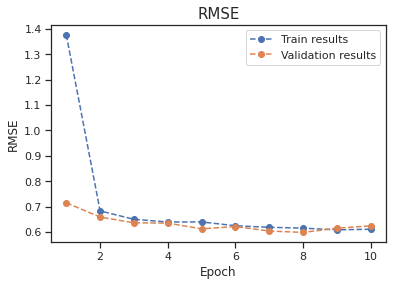

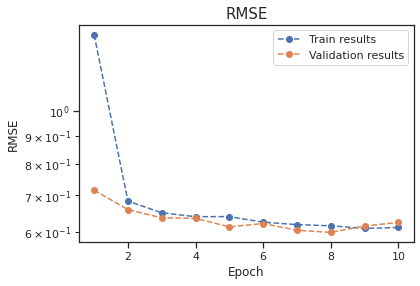

In [18]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear')
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

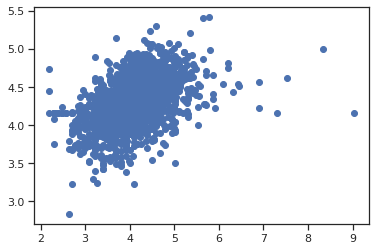

(0.44774102953267314, 4.025649390032662e-85)

In [24]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

ys = []
ypreds = []

with torch.no_grad():
    model = model1.eval()

    for ids, labels, masks in valloader:
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model1(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


plt.scatter(ys, ypreds)
plt.show()
pearsonr(ys, ypreds)

## Inference testing

In [30]:
import explainability_utils as explain
text = "This is a luxurious spa appartment, with the best location in the centre of downtown vienna"
attention = explain.pipeline(text, model1, device)
explain.visualize_attention(text, attention)

138.23348999023438


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


## [Optional] Fine-tune BERT model

(This is a non-mandatory, fully optional task)

Can you improve performance by fine-tuning BERT in addition to training the readout classifier?

In [32]:
b = 32
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)
model2 = LanguageBertNet(fine_tune=True, with_attention_masks=True, cls_dropout_prob=0.5)
model2 = model2.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)
result = train.run_training(model2, optimizer, loss_fn, device, 20, trainloader, valloader, verbose=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saving model...
Saving model...
Saving model...
Saving model...


Finished training after 2588 seconds.


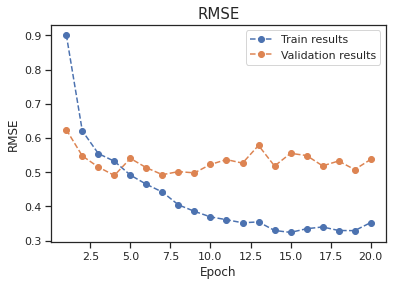

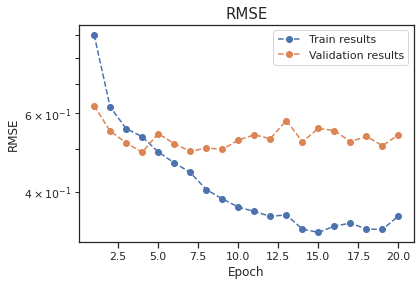

In [34]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear')
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

In [35]:
model2.load_state_dict(torch.load("/content/checkpoints/checkpoint.pt"))

<All keys matched successfully>

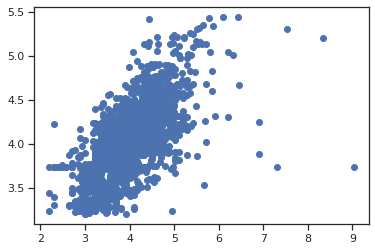

(0.647111194928171, 1.3197105624940958e-203)

In [38]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

ys = []
ypreds = []

with torch.no_grad():
    model = model2.eval()

    for ids, labels, masks in valloader:
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


plt.scatter(ys, ypreds)
plt.show()
pearsonr(ys, ypreds)

In [40]:
text = "This is a modest appartment, with a backyard location in the centre of downtown vienna"
attention = explain.pipeline(text, model1, device)
explain.visualize_attention(text, attention)

104.84989166259766


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"
